# Optimization of an X-Gate for a Transmon Qubit

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
krotov      0.0.1
CPython 3.6.7
IPython 7.1.1


## Define the Hamiltonian

In [2]:
def transmon_ham_and_states(Ec=0.386, EjEc=45, nstates=8, ng=0.0, T=10.0, steps=1000):
    """Transmon Hamiltonian"""
    Ej = EjEc * Ec
    n = np.arange(-nstates, nstates+1)
    up = np.diag(np.ones(2*nstates),k=-1)
    do = up.T
    H0 = qutip.Qobj(np.diag(4*Ec*(n - ng)**2) - Ej*(up+do)/2.0)
    H1 = qutip.Qobj(-2*np.diag(n))
    
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:,ndx]
    w01 = E[1]-E[0] # Transition energy between states
    
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])    
    
    profile = lambda t: np.exp(-40.0*(t/T - 0.5)**2)
    eps0 = lambda t, args: 0.5 * profile(t) * np.cos(8*np.pi*w01*t)
    return ([H0, [H1, eps0]], psi0, psi1)

In [3]:
H, psi0, psi1 = transmon_ham_and_states()

In [4]:
proj0 = psi0 * psi0.dag()
proj1 = psi1 * psi1.dag()

In [5]:
tlist = np.linspace(0, 10, 1000)

## Simulate dynamics of the guess pulse

In [6]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

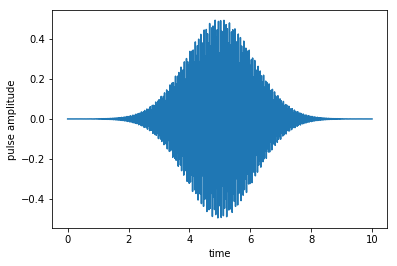

In [7]:
plot_pulse(H[1][1], tlist)

In [8]:
guess_dynamics = qutip.mesolve(H, psi0, e_ops=[proj0, proj1], tlist=tlist)

In [9]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

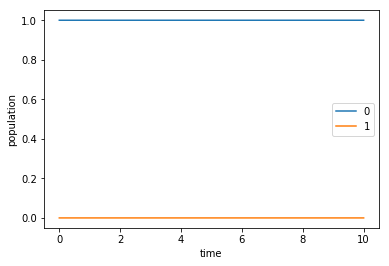

In [10]:
plot_population(guess_dynamics)

## Optimize

In [11]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [12]:
objectives = [
    krotov.Objective(initial_state=psi0, target_state=psi1, H=H),
    krotov.Objective(initial_state=psi1, target_state=psi0, H=H)
]

def S(t):
    dt = tlist[1] - tlist[0]
    steps = len(tlist)
    return np.exp(-40.0*(t/((steps-1)*dt)-0.5)**2)

pulse_options = {
    H[1][1]: krotov.PulseOptions(lambda_a=1, shape=S)
}

def print_fidelity(**args): 
    F_re = np.average(np.array(args['tau_vals']).real)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

In [13]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=3)

INFO:krotov:Initializing optimization with Krotov's method
INFO:krotov:Started initial forward propagation of objective 0
INFO:krotov:Finished initial forward propagation of objective 0
INFO:krotov:Started initial forward propagation of objective 1
INFO:krotov:Finished initial forward propagation of objective 1
INFO:krotov:Started Krotov iteration 1
INFO:krotov:Started backward propagation of state 0


Iteration 0: 	F = 0.000000


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started backward propagation of state 1
INFO:krotov:Finished backward propagation of state 1
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 1
INFO:krotov:Started Krotov iteration 2
INFO:krotov:Started backward propagation of state 0


Iteration 1: 	F = 0.107181


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started backward propagation of state 1
INFO:krotov:Finished backward propagation of state 1
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 2
INFO:krotov:Started Krotov iteration 3
INFO:krotov:Started backward propagation of state 0


Iteration 2: 	F = 0.410152


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started backward propagation of state 1
INFO:krotov:Finished backward propagation of state 1
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 3


Iteration 3: 	F = 0.694378


In [14]:
# NBVAL_IGNORE_OUTPUT
oct_result

Krotov Optimization Result
--------------------------
- Started at 2018-11-13 12:13:25
- Number of objectives: 2
- Number of iterations: 3
- Ended at 2018-11-13 12:13:53

In [15]:
["%.2e" % F for F in oct_result.info_vals]

['1.94e-08', '1.07e-01', '4.10e-01', '6.94e-01']

In [16]:
logger.setLevel(logging.WARN)

## Simulate dynamics of the optimized pulse

In [17]:
oct_control = oct_result.optimized_controls[0]

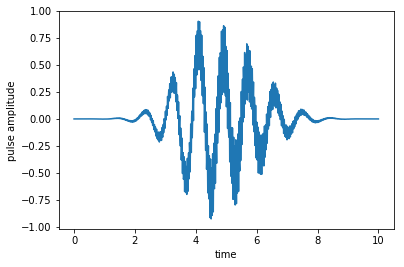

In [18]:
plot_pulse(oct_control, tlist)

In [19]:
# this works around https://github.com/qutip/qutip/issues/932
# once that issue is resolved, we can use oct_control directly
T = tlist[-1]; nt=len(tlist)
oct_control_func = lambda t, args: (0 if (t > float(T)) else oct_control[int(round(float(nt-1) * (t/float(T))))])

In [20]:
H_opt = [H[0], [H[1][0], oct_control]]

In [21]:
opt_dynamics = qutip.mesolve(H_opt, psi0, e_ops=[proj0, proj1], tlist=tlist)

/Users/goerz/Documents/Programming/github/krotov/.venv/py36/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/goerz/Documents/Programming/github/krotov/docs/notebooks/rhs873080.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


ImportError: Building module rhs873080 failed: ["distutils.errors.CompileError: command 'gcc' failed with exit status 1\n"]

In [ ]:
plot_population(opt_dynamics)